                 time  prices
time                         
2020-10-16 2020-10-16    7.07
2020-10-15 2020-10-15    7.04
2020-10-14 2020-10-14    6.85
2020-10-13 2020-10-13    6.95
2020-10-12 2020-10-12    6.96
               prices
time                 
2011-09-30  23.385000
2011-10-31  25.367500
2011-11-30  26.827727
2011-12-31  22.894545
2012-01-31  20.243333
...               ...
2020-06-30   7.218500
2020-07-31   7.094783
2020-08-31   7.286190
2020-09-30   6.739091
2020-10-31   6.955000

[110 rows x 1 columns]


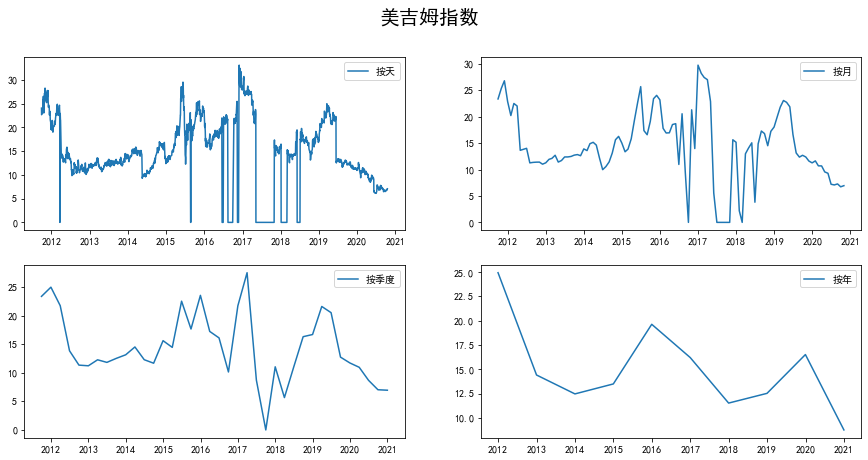

最优模型:                                ARMA Model Results                              
Dep. Variable:                 prices   No. Observations:                  110
Model:                     ARMA(1, 0)   Log Likelihood                -324.786
Method:                       css-mle   S.D. of innovations              4.620
Date:                Tue, 20 Oct 2020   AIC                            655.572
Time:                        22:54:57   BIC                            663.673
Sample:                    09-30-2011   HQIC                           658.858
                         - 10-31-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           14.4883      1.524      9.508      0.000      11.502      17.475
ar.L1.prices     0.7174      0.067     10.743      0.000       0.586       0.848
                                    R

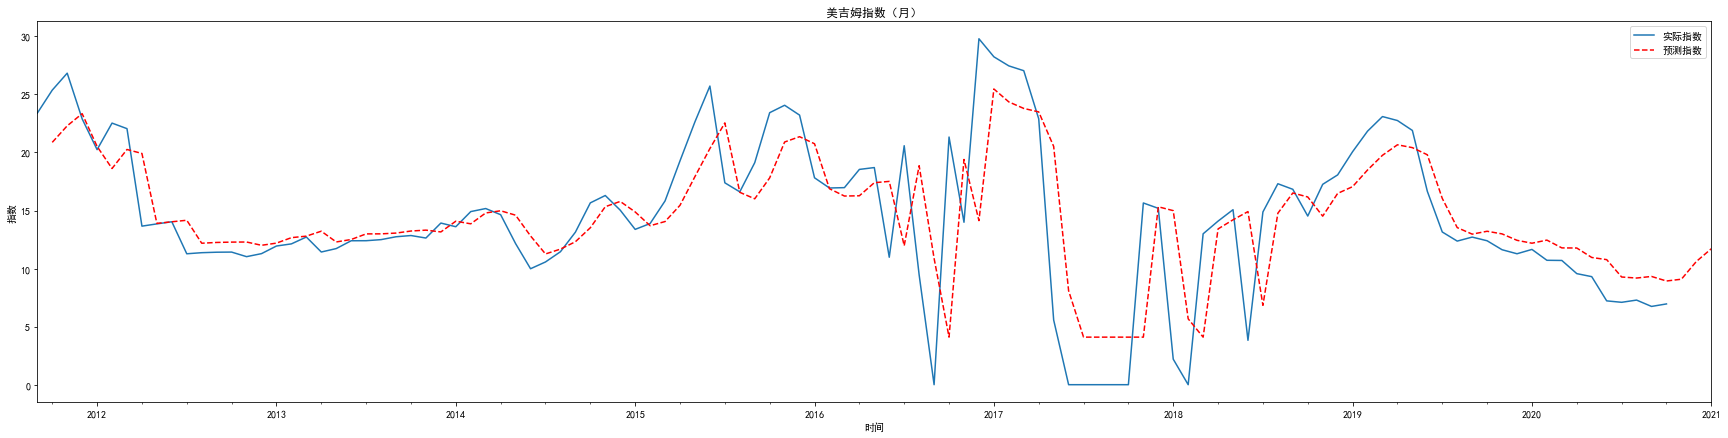

In [10]:
# -*- coding: utf-8 -*-
# 时间序列ARMA去预测美吉姆
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# tsa的模型
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

warnings.filterwarnings('ignore')
# 数据加载, 美吉姆数据加载
df = pd.read_csv('./002621.csv')
df = df[['time', 'prices']]

# 将时间作为df的索引
df.time = pd.to_datetime(df.time)
df.index = df.time
# 数据探索
print(df.head())
# 按照月
df_month = df.resample('M').mean()
# 按季度
df_Q = df.resample('Q-DEC').mean()
#按年
df_year = df.resample('A-DEC').mean()
print(df_month)
#print(df_Q)
#print(df_year)

# 按照天，月，季度，年来显示美吉姆指数的走势
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['SimHei'] 
#用来正常显示中文标签
plt.suptitle('美吉姆指数', fontsize=20)
plt.subplot(221)
plt.plot(df.prices, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.prices, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.prices, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.prices, '-', label='按年')
plt.legend()
plt.show()

# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.prices,order=(param[0], param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

    # 输出最优模型
print('最优模型: ', best_model.summary())

# 设置future_month，需要预测的时间date_list
df_month2 = df_month[['prices']]
# 设置三个月
future_month = 3
last_month = pd.to_datetime(df_month2.index[len(df_month2)-1])
#print(last_month)
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    next_month_days = calendar.monthrange(year, month)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=next_month_days)
    date_list.append(last_month)
print('date_list=', date_list)

# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=len(df_month2))
# 第一个元素不正确，设置为NaN
df_month2['forecast'][0] = np.NaN
print(df_month2)

# 美吉姆指数预测结果显示
plt.figure(figsize=(30,7))
df_month2.prices.plot(label='实际指数')
df_month2.forecast.plot(color='r', ls='--', label='预测指数')
plt.legend()
plt.title('美吉姆指数（月）')
plt.xlabel('时间')
plt.ylabel('指数')
plt.show()
